In [1]:
from __future__ import annotations

import pathlib
import warnings

import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits

%matplotlib inline
import galstreams
from astroquery.gaia import Gaia
from pyia import GaiaData
from scipy.interpolate import InterpolatedUnivariateSpline

        Use @ instead. [gala.coordinates.sgr]
        Use @ instead. [gala.coordinates.orphan]
        Use @ instead. [gala.coordinates.magellanic_stream]


In [2]:
data_path = pathlib.Path("../data/").resolve().absolute()
data_path.mkdir(exist_ok=True, parents=True)

In [15]:
streams = {
    #     'GD-1': 'GD-1-PB18',
    #     'Pal5': 'Pal5-PW19',
    #     'Jhelum': 'Jhelum-b-B19',
    #     'Fjorm-M68': 'M68-P19',
    #     'PS1-A': 'PS1-A-B16',
    "Gunnthra": "Gunnthra-I21"
}
stds = {
    #     'GD-1': 1.,
    #     'Pal5': 1.,
    #     'Jhelum': 2.5,
    #     'Fjorm-M68': 1.,
    #     'PS1-A': 1.,
    "Gunnthra": 4,
}

## Load existing/previously run jobs in the Gaia archive

In [8]:
Gaia.login(credentials_file=pathlib.Path("~/.gaia/archive.login").expanduser())

INFO: Login to gaia TAP server [astroquery.gaia.core]
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK


In [9]:
jobs = Gaia.list_async_jobs()
jobs = [Gaia.load_async_job(jobid=j.jobid, load_results=False) for j in jobs]
jobs = {j.parameters["jobname"]: j for j in jobs if j.is_finished()}

phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase was set
phase 

## Define the base query and column names to retrieve:

In [10]:
gaia_columns = [
    "source_id",
    "ra",
    "dec",
    "parallax",
    "parallax_error",
    "pmra",
    "pmra_error",
    "pmdec",
    "pmdec_error",
    "ra_parallax_corr",
    "ra_pmra_corr",
    "ra_pmdec_corr",
    "dec_parallax_corr",
    "dec_pmra_corr",
    "dec_pmdec_corr",
    "parallax_pmra_corr",
    "parallax_pmdec_corr",
    "pmra_pmdec_corr",
    "phot_g_mean_mag",
    "phot_g_mean_flux_over_error",
    "phot_bp_mean_mag",
    "phot_bp_mean_flux_over_error",
    "phot_rp_mean_mag",
    "phot_rp_mean_flux_over_error",
    "ruwe",
    "astrometric_matched_transits",
]

In [11]:
base_query = """
SELECT {columns}
FROM gaiadr3.gaia_source
WHERE parallax < 1 AND bp_rp > -2 AND bp_rp < 4 AND
      CONTAINS(POINT('ICRS', ra, dec), 
               POLYGON('ICRS', 
                       {c[0].ra.degree}, {c[0].dec.degree}, 
                       {c[1].ra.degree}, {c[1].dec.degree}, 
                       {c[2].ra.degree}, {c[2].dec.degree}, 
                       {c[3].ra.degree}, {c[3].dec.degree})) = 1
"""

## Load galstreams tracks:

In [3]:
mws = galstreams.MWStreams(verbose=False, implement_Off=True)

Initializing galstreams library from master_log... 


        Use @ instead. [gala.coordinates.greatcircle]


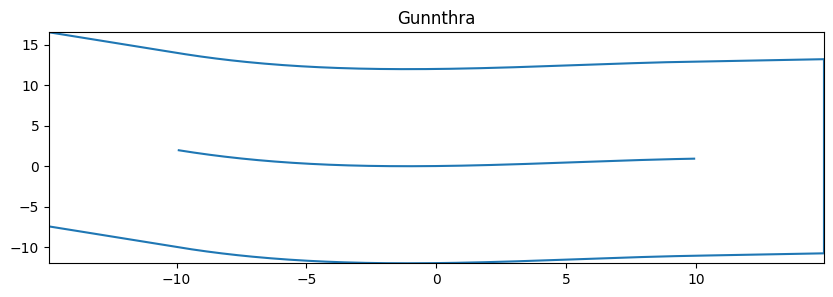

In [16]:
windows = {}
for name, gs_name in streams.items():
    gs = mws[gs_name]

    track = gs.track.transform_to(gs.stream_frame)

    if name == "Pal5":
        # extrapolation of the track went wonky for pal 5
        spl = InterpolatedUnivariateSpline(
            track.phi1.degree[20:-10], track.phi2.degree[20:-10], k=1
        )
    else:
        spl = InterpolatedUnivariateSpline(track.phi1.degree, track.phi2.degree, k=1)

    if name == "GD-1":
        grid_phi1 = np.linspace(-100, 20, 256)
    else:
        # extend track by +/- 5 deg in phi1:
        grid_phi1 = np.linspace(
            track.phi1.degree.min() - 5, track.phi1.degree.max() + 5, 256
        )
    grid_phi2 = spl(grid_phi1)

    phi1 = np.concatenate(
        (
            grid_phi1,
            grid_phi1[::-1],
        )
    )
    phi2 = np.concatenate(
        (
            grid_phi2 - 3 * stds[name],
            grid_phi2[::-1] + 3 * stds[name],
        )
    )

    fig, ax = plt.subplots(figsize=(10, 3))
    ax.plot(track.phi1.degree, track.phi2.degree)
    ax.plot(phi1, phi2, color="tab:blue")
    ax.set_title(name)

    windows[name] = [(phi1.min(), phi1.max()), (phi2.min(), phi2.max())]
    ax.set_xlim(windows[name][0])
    ax.set_ylim(windows[name][1])

## Run queries

In [19]:
dphi1 = 10.0
for name, gs_name in streams.items():
    gs = mws[gs_name]

    this_path = data_path / name
    this_path.mkdir(exist_ok=True)

    phi1_lim, phi2_lim = windows[name]

    phi1_grid = np.clip(
        np.arange(phi1_lim[0], phi1_lim[1] + dphi1, dphi1), phi1_lim[0], phi1_lim[1]
    )

    _jobs = {}
    for i, (l, r) in enumerate(zip(phi1_grid[:-1], phi1_grid[1:])):
        filename = this_path / f"poly_{i:02d}.fits"
        jobname = f"{name}_{i:02d}"

        print(i, l, r, filename, jobname)

        if filename.exists():
            continue

        #         elif not filename.exists() and jobname in jobs:
        #             # TODO: download job and save file
        #             pass

        else:
            corners = coord.SkyCoord(
                phi1=[l, l, r, r] * u.deg,
                phi2=[phi2_lim[0], phi2_lim[1], phi2_lim[1], phi2_lim[0]] * u.deg,
                frame=gs.stream_frame,
            ).icrs

            query = base_query.format(columns=", ".join(gaia_columns), c=corners)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                job = Gaia.launch_job_async(query, name=jobname, background=True)
            _jobs[filename] = job

    if _jobs:
        for fn, job in _jobs.items():
            tbl = job.get_results()
            tbl.write(fn, overwrite=True)

0 -14.91715213769146 -4.91715213769146 /Users/Tavangar/Work/CATS_Workshop/cats/data/Gunnthra/poly_00.fits Gunnthra_00


        Use @ instead. [gala.coordinates.greatcircle]


1 -4.91715213769146 5.08284786230854 /Users/Tavangar/Work/CATS_Workshop/cats/data/Gunnthra/poly_01.fits Gunnthra_01


        Use @ instead. [gala.coordinates.greatcircle]


2 5.08284786230854 14.931630538540805 /Users/Tavangar/Work/CATS_Workshop/cats/data/Gunnthra/poly_02.fits Gunnthra_02


        Use @ instead. [gala.coordinates.greatcircle]


500 Error 500:
null


HTTPError: Error 500:
null

## Combine tables

In [50]:
from numpy.lib.recfunctions import stack_arrays

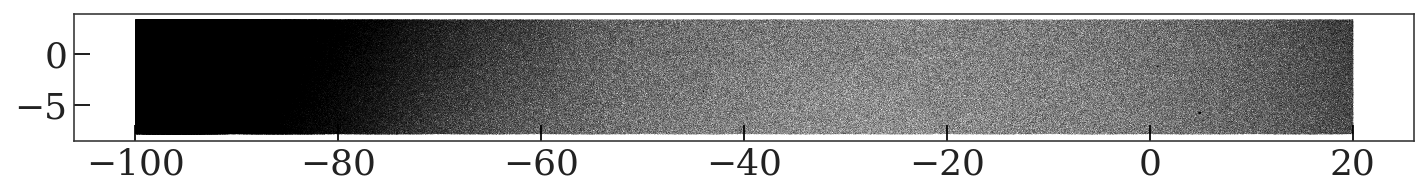

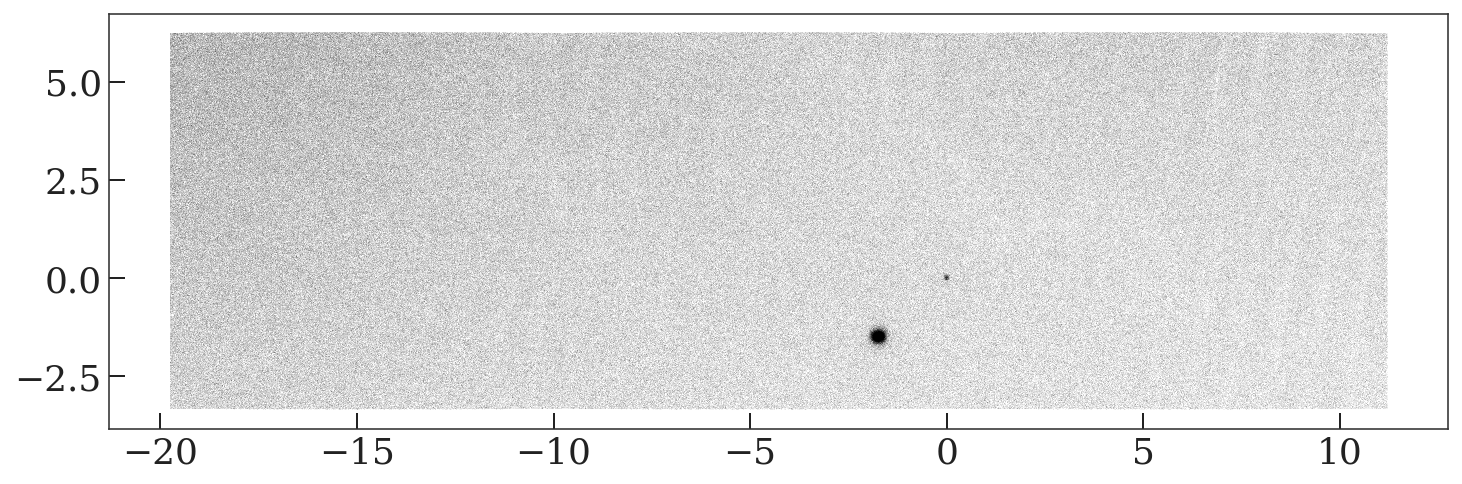

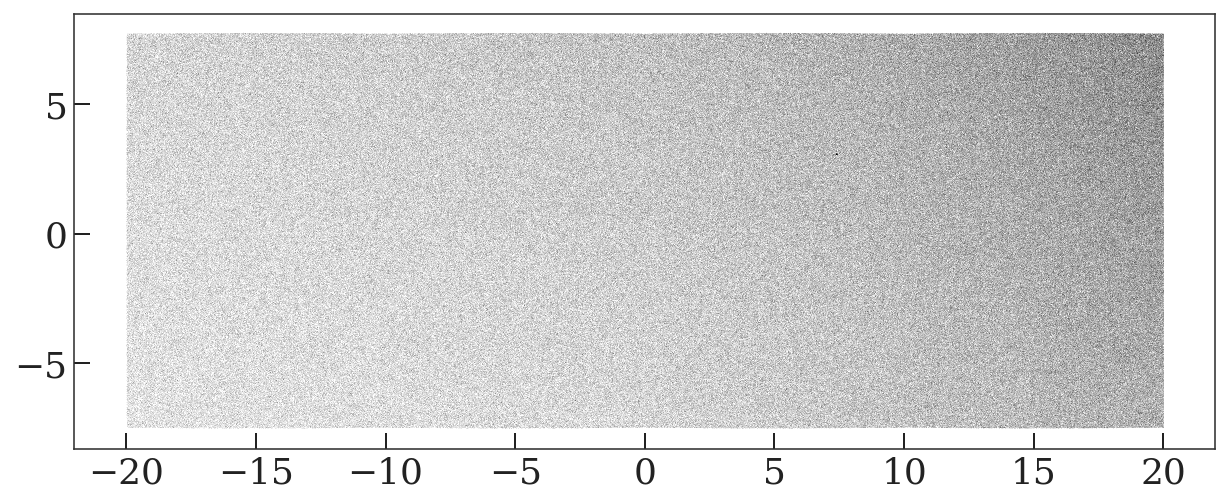

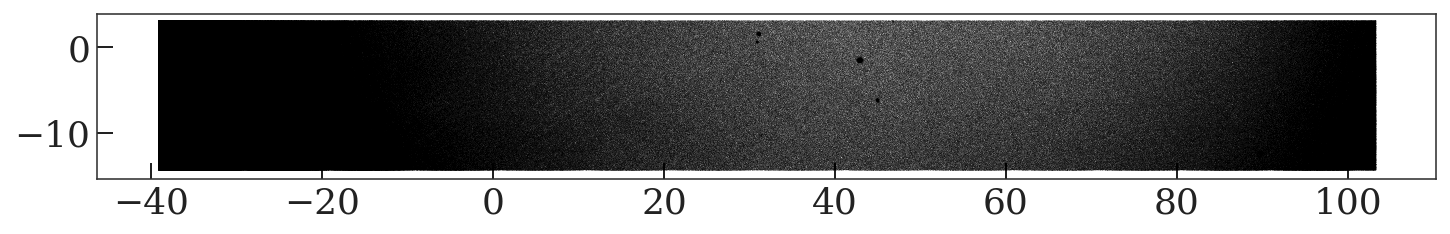

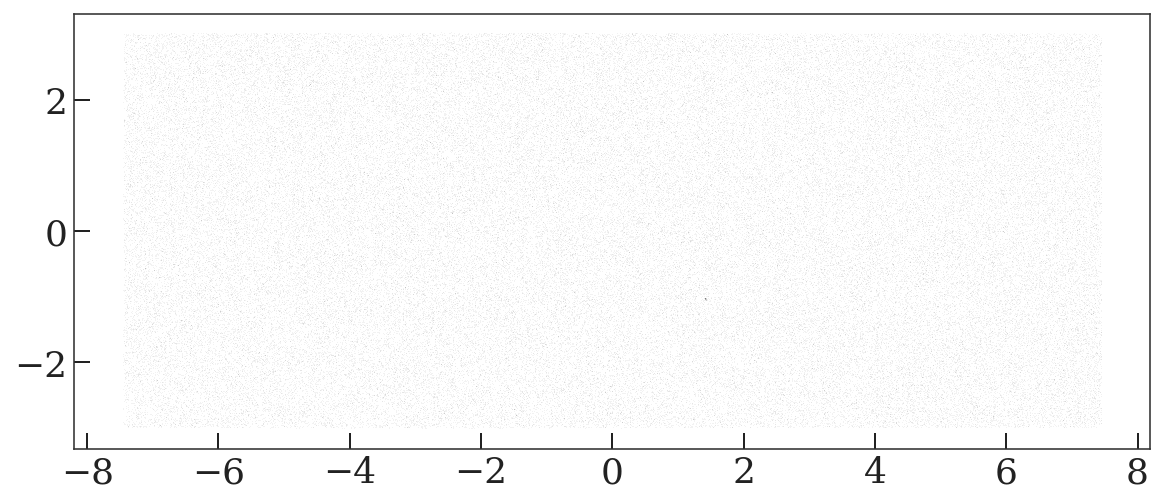

In [51]:
for name, gs_name in streams.items():
    gs = mws[gs_name]

    this_path = data_path / name

    all_filename = pathlib.Path(data_path / f"GaiaDR3-{name}-all.fits")
    if all_filename.exists():
        continue

    arrs = []
    for filename in this_path.glob("poly_*.fits"):
        arrs.append(np.array(fits.getdata(filename)))
    arr = stack_arrays(arrs, asrecarray=True, usemask=False)

    t = at.Table(arr)
    t = at.unique(t, keys="source_id")

    c = coord.SkyCoord(
        t["ra"] * u.deg,
        t["dec"] * u.deg,
    ).transform_to(gs.stream_frame)
    t["phi1"] = c.phi1.degree
    t["phi2"] = c.phi2.degree

    t.write(all_filename, overwrite=True)

    # ---

    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    ax.plot(
        c.phi1.wrap_at(180 * u.deg), c.phi2, marker=",", linestyle="none", alpha=0.05
    )
    ax.set_aspect("equal")

## Joining the crossmatch results with Gaia data

In [ ]:
ps1 = at.Table.read("PS!_Gaia_XM_file.fits")  # downloaded from MAST results
tbl = GaiaData("Gaia_file.fits")  # Gaia file from before

joined = at.join([ps1, tbl], keys="source_id")  # join the two tables
print(joined)  # check that this does what we want

joined.write("joined-Ophiuchus.fits", overwrite=True)